In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import h5py
import glob 
from scipy import interpolate
import json
import os
import sys
from NuRadioReco.utilities import units
from NuRadioReco.detector import detector
from NuRadioMC.utilities import fluxes
from NuRadioMC.utilities.Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
#from my_Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
from NuRadioMC.examples.Sensitivities import E2_fluxes3 as limits
from Get_hdf5_data import get_attr_data, get_shower_data, get_station_data, get_Veff_data, get_event_data, get_nur_data
from Peak_Finding import count_peak, get_noise, save_data_2_csv, read_column_csv
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import NuRadioReco.detector.detector as detector
import NuRadioReco.modules.io.eventReader
import astropy
from NuRadioReco.framework.parameters import stationParameters as stnp
import pandas as pd
from math import isclose
import mplhep as hep

temp_stdout = None
# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout

PATH = "/home/teikiet/Data/"
##########################################################################
S_ID = [100,2, 3, 4, 5] #station ID
C_ID = list(range(0,16)) #channel ID
##########################################################################
threshold = 5 #threshold
bin_size = 11 #bin size aka time interval x0.625 ns
sample_size = 800 #the time interval for peak detection x0.625ns
E = 18 #energy
num =  1e3 #number of particles
detectordescription = "detector/ara2.json" #detector 
##########################################################################
#Nur path:
inputfilename1 = PATH + f"sims_monopoles_ara2_n1.000e03_4_18to20/Nur/1.000e{E}/"
inputfilename2 = PATH + f"sims_neutrinos_ara2_n1.000e03_4_18to21/Nur/sim_1.000e{E}.nur"
##########################################################################
#Hdf5 path:
path1 = PATH + f'sims_monopoles_ara2_n1.000e03_4_18to20/Hdf5/1.000e{E}'
path2 = PATH + f'sims_neutrinos_ara2_n1.000e03_4_18to21/Hdf5/sim_1.000e{E}.hdf5'
get_attr_data(path2)
##########################################################################



Attributes of hdf5: ['Emax', 'Emin', 'NuRadioMC_EvtGen_version', 'NuRadioMC_EvtGen_version_hash', 'NuRadioMC_version', 'NuRadioMC_version_hash', 'Tnoise', 'VERSION_MAJOR', 'VERSION_MINOR', 'Vrms', 'area', 'bandwidth', 'config', 'deposited', 'detector', 'dt', 'fiducial_rmax', 'fiducial_rmin', 'fiducial_zmax', 'fiducial_zmin', 'flavors', 'header', 'n_events', 'n_samples', 'phimax', 'phimin', 'rmax', 'rmin', 'start_event_id', 'thetamax', 'thetamin', 'total_number_of_events', 'trigger_names', 'volume', 'zmax', 'zmin']
Keys of hdf5: ['azimuths', 'energies', 'event_group_ids', 'flavors', 'inelasticity', 'interaction_type', 'multiple_triggers', 'n_interaction', 'shower_energies', 'shower_ids', 'shower_realization_Alvarez2009', 'shower_type', 'station_100', 'station_2', 'station_3', 'station_4', 'station_5', 'trigger_times', 'triggered', 'vertex_times', 'weights', 'xx', 'yy', 'zeniths', 'zz']


In [2]:
E = [18, 19, 20]
#MM = np.array([4, 8, 14]) #1e3
Neu = np.array([11, 27, 96]) #1e3
MM= np.array([67, 98, 196]) #1e4
threshold = 5
p1 = []
p2 = []

e1 = []
e2 = []

n = 0
for i in E:
    data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{i}.csv'
    data2 = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e03_1e{i}.csv'
    
    blockPrint()
    V_peak1, T_peak1, PEAK1, NOISE1, _ = count_peak(data1, S_ID, C_ID, bin_size, threshold, sample_size)
    V_peak2, T_peak2, PEAK2, NOISE2, _ = count_peak(data2, S_ID, C_ID, bin_size, threshold, sample_size)
    h1 = np.histogram(PEAK1, bins=int(max(PEAK1)-min(PEAK1))+1, range=(min(PEAK1)-0.5, max(PEAK1)+0.5))
    h2 = np.histogram(PEAK2, bins=int(max(PEAK2)-min(PEAK2))+1, range=(min(PEAK2)-0.5, max(PEAK2)+0.5))
    enablePrint()

    p1_i = np.array(h1[0])/MM[n]
    p2_i = np.array(h2[0])/Neu[n]
    print(p1_i)
    print(p2_i)

    e1_i = np.sqrt(np.array(h1[0]))/MM[n]
    e2_i = np.sqrt(np.array(h2[0]))/Neu[n]

    if len(p1_i) < 30 or len(p2_i) < 30:
        p1_i = np.append(p1_i, np.zeros(30-len(p1_i)))
        e1_i = np.append(e1_i, np.zeros(30-len(e1_i)))
        #####################################
        p2_i = np.append(p2_i, np.zeros(30-len(p2_i)))
        e2_i = np.append(e2_i, np.zeros(30-len(e2_i)))

    p1.append(p1_i)
    p2.append(p2_i)

    e1.append(e1_i)
    e2.append(e2_i)

    n += 1

p1 = np.array(p1)
p2 = np.array(p2)


[27.59701493  5.89552239  0.37313433]
[31.09090909  8.09090909  0.36363636]
[2.57142857e+01 4.94897959e+00 1.84693878e+00 3.16326531e-01
 1.02040816e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.02040816e-02 0.00000000e+00 1.02040816e-02]
[30.2962963  12.74074074  0.48148148]
[1.82040816e+01 1.75000000e+00 1.28571429e+00 9.43877551e-01
 6.88775510e-01 3.77551020e-01 1.63265306e-01 6.12244898e-02
 4.08163265e-02 1.53061224e-02 3.06122449e-02 1.53061224e-02
 0.00000000e+00 2.04081633e-02 1.02040816e-02 5.10204082e-03
 2.55102041e-02 1.53061224e-02]
[24.78125    13.36458333  2.3125    ]


In [3]:
#Amplification
P1 = p1 * 200
P2 = p2 * 200


In [4]:
P5_1 = P1[:,5]
for i in range(6,30):
    P5_1 += P1[:,i]

P5_2 = P2[:,5]
for i in range(6,30):
    P5_2 += P2[:,i]

Text(0.5, 1.0, '$N_{peak}$ per event vs $E$ at 5 threshold')

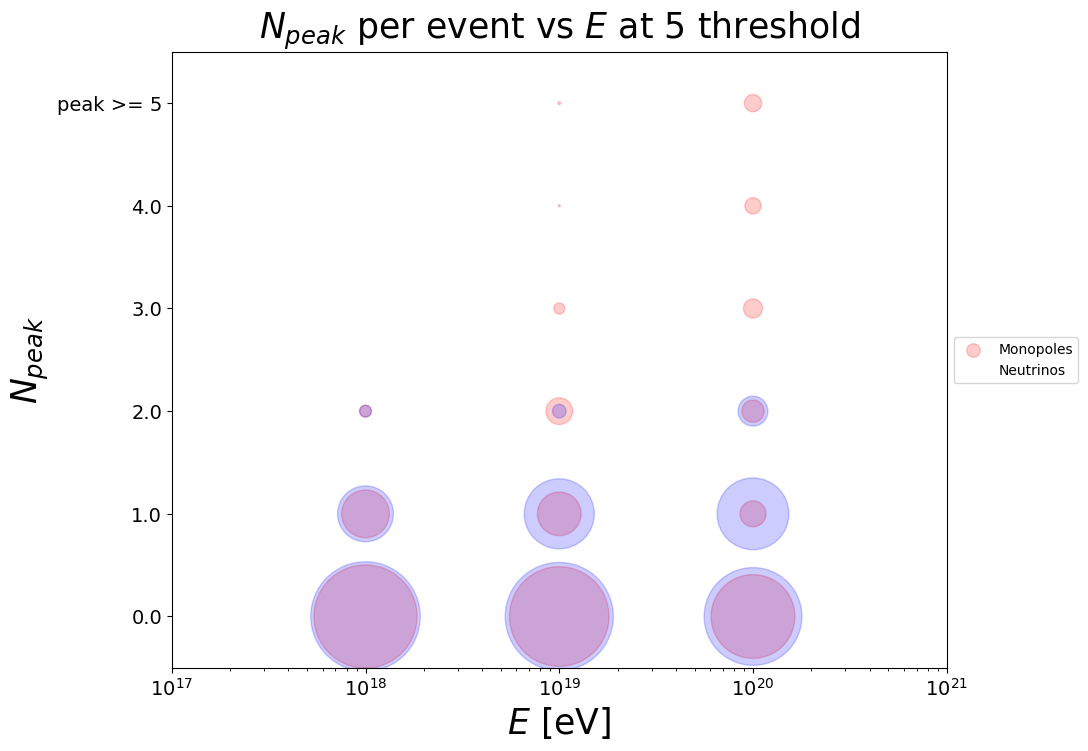

In [5]:
#Ploting graph
import matplotlib.ticker as mticker
e = np.array([1e18, 1e19, 1e20])
e1 = e-10000
e2 = e+10000
plt.figure(figsize=(10, 8))
plt.scatter(e1, [0, 0, 0], s = P1[:,0], color = "red", alpha=0.2)
plt.scatter(e1, [1, 1, 1], s = P1[:,1],  color = "red", alpha=0.2)
plt.scatter(e1, [2, 2, 2], s = P1[:,2],  color = "red", alpha=0.2)
plt.scatter(e1, [3, 3, 3], s = P1[:,3],  color = "red", alpha=0.2, label=f'Monopoles')
plt.scatter(e1, [4, 4, 4], s = P1[:,4],  color = "red", alpha=0.2)
plt.scatter(e1, [5, 5, 5], s = P5_1,  color = "red", alpha=0.2)


plt.scatter(e2, [0, 0, 0], s = P2[:,0], color = "blue", alpha=0.2)
plt.scatter(e2, [1, 1, 1], s = P2[:,1],  color = "blue", alpha=0.2)
plt.scatter(e2, [2, 2, 2], s = P2[:,2],  color = "blue", alpha=0.2)
plt.scatter(e2, [3, 3, 3], s = P2[:,3],  color = "blue", alpha=0.2, label=f'Neutrinos')
plt.scatter(e2, [4, 4, 4], s = P2[:,4],  color = "blue", alpha=0.2)
plt.scatter(e2, [5, 5, 5], s = P5_2,  color = "blue", alpha=0.2)

def update_ticks(y, pos):
    if y == 5:
        return 'peak >= 5'
    else:
        return y
plt.subplot().yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
    
#plt.yscale('log')
plt.xscale('log')
plt.ylim(-0.5, 5.5)
plt.xlim(1e17, 1e21)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$E$ [eV]', fontsize=25)
plt.ylabel(r'$N_{peak}$', fontsize=25)
plt.title(r'$N_{peak}$ per event vs $E$ at '+ f'{threshold} threshold', fontsize=25)

In [6]:
P5 == P1[:,5]
for i in range(6,30):
    P5 += P1[:,i]
P5

NameError: name 'P5' is not defined

In [20]:
P1[:,5]

array([  0.        ,  32.65306122, 720.40816327])

In [55]:
a

[3, 6, 9, 12, 15]

NameError: name 'y' is not defined

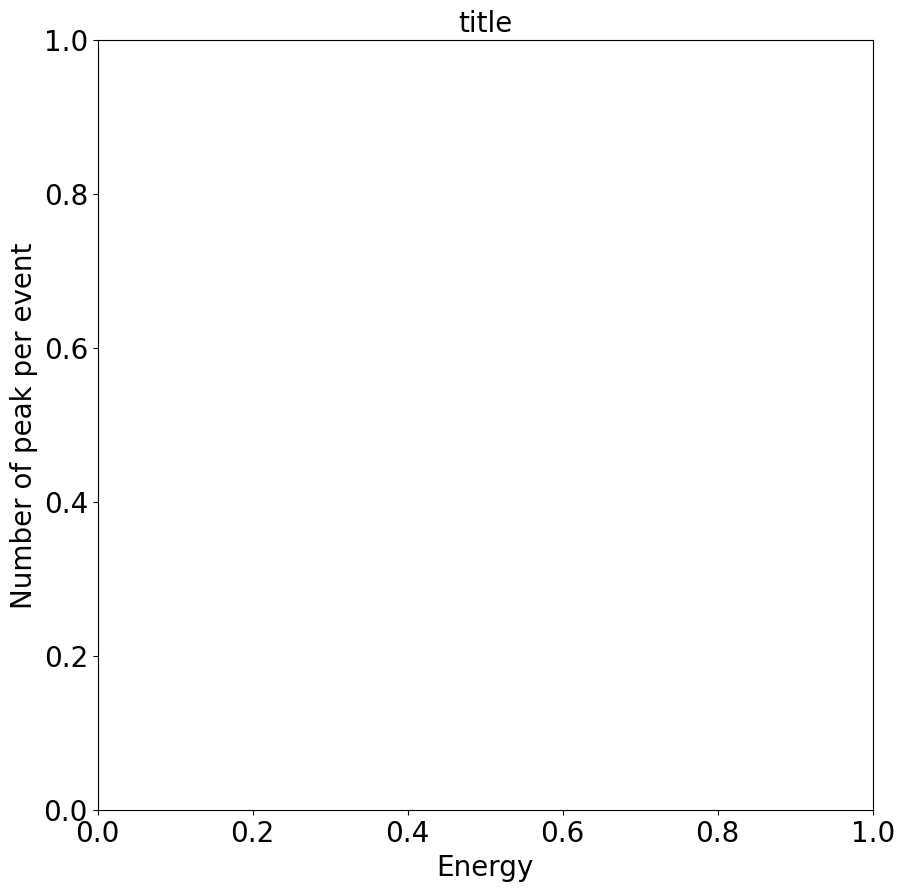

In [7]:
#make plot with varying dot size:
plt.figure(figsize=(10,10))
plt.title("title", fontsize=20)
plt.xlabel("Energy", fontsize=20)
plt.ylabel("Number of peak per event", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.scatter(E, y, s=s, c=c, cmap="Plasma", vmin=vmin, vmax=vmax)
plt.colorbar()


In [13]:
Threshold = np.arange(1, 5, 0.2)
E = 20
##########################################################################
p1 = []
p2 = []
##########################################################################
e1 = []
e2 = []
##########################################################################
for i in Threshold:
    print("threshold: ",i)
    blockPrint()
    data1 = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e04_1e{E}.csv'
    data2 = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e03_1e{E}.csv'
    ######################################################################
    V_peak1, T_peak1, PEAK1, NOISE1, d_T_peak1 = count_peak(data1, S_ID, C_ID, bin_size, i, sample_size)
    V_peak2, T_peak2, PEAK2, NOISE2, d_T_peak2 = count_peak(data2, S_ID, C_ID, bin_size, i, sample_size)
    ######################################################################
    h1 = np.histogram(PEAK1, bins=int(max(PEAK1)-min(PEAK1))+1, range=(min(PEAK1)-0.5, max(PEAK1)+0.5))
    h2 = np.histogram(PEAK2, bins=int(max(PEAK2)-min(PEAK2))+1, range=(min(PEAK2)-0.5, max(PEAK2)+0.5))
    ######################################################################
    ######################################################################
    r1 = h1[0]/sum(h1[0]) #ratio1
    r2 = h2[0]/sum(h2[0]) #ratio2
    print(len(r1))
    print(len(r2))
    if len(r1) < 40 or len(r2) < 40:
        r1 = np.append(r1, np.zeros(40-len(r1)))
        #####################################
        r2 = np.append(r2, np.zeros(40-len(r2)))
    enablePrint()
    #error:
    err1 = np.sqrt(r1*sum(h1[0]))/sum(h1[0])
    err2 = np.sqrt(r2*sum(h2[0]))/sum(h2[0])
    ######################################################################

    ######################################################################
    p1.append(list(r1))
    p2.append(list(r2))
    e1.append(list(err1))
    e2.append(list(err2))
    print(min(PEAK1), min(PEAK2))
    ######################################################################
#Convert to percentage:
p1 = np.array(p1)*100
p2 = np.array(p2)*100
######################################################################
e1 = np.array(e1)*100
e2 = np.array(e2)*100

threshold:  1.0
0.0 11.0
threshold:  1.2
0.0 11.0
threshold:  1.4
0.0 11.0
threshold:  1.5999999999999999
0.0 11.0
threshold:  1.7999999999999998
0.0 10.0
threshold:  1.9999999999999998
0.0 7.0
threshold:  2.1999999999999997
0.0 4.0
threshold:  2.3999999999999995
0.0 2.0
threshold:  2.5999999999999996
0.0 0.0
threshold:  2.8
0.0 0.0
threshold:  2.9999999999999996
0.0 0.0
threshold:  3.1999999999999993
0.0 0.0
threshold:  3.3999999999999995
0.0 0.0
threshold:  3.5999999999999996
0.0 0.0
threshold:  3.7999999999999994
0.0 0.0
threshold:  3.999999999999999
0.0 0.0
threshold:  4.199999999999999
0.0 0.0
threshold:  4.3999999999999995
0.0 0.0
threshold:  4.6
0.0 0.0
threshold:  4.799999999999999
0.0 0.0


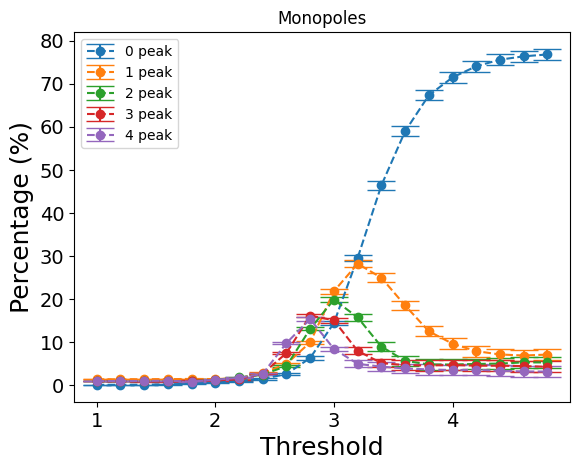

In [14]:
plt.errorbar(Threshold, p1[:,0], yerr=e1[:,0], fmt='o--', capsize= 10, label="0 peak")
plt.errorbar(Threshold, p1[:,1], yerr=e1[:,0], fmt='o--', capsize= 10, label="1 peak")
plt.errorbar(Threshold, p1[:,2], yerr=e1[:,0], fmt='o--', capsize= 10, label="2 peak")
plt.errorbar(Threshold, p1[:,3], yerr=e1[:,0], fmt='o--', capsize= 10, label="3 peak")
plt.errorbar(Threshold, p1[:,4], yerr=e1[:,0], fmt='o--', capsize= 10, label="4 peak")

plt.xlabel("Threshold")
plt.ylabel("Percentage (%)")
plt.title("Monopoles")
plt.legend()
plt.show()

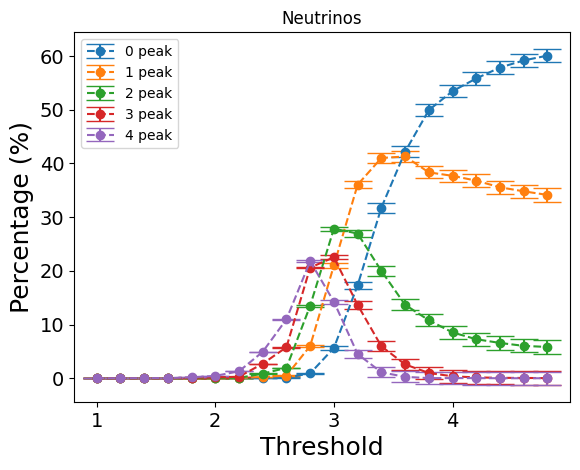

In [15]:
plt.errorbar(Threshold, p2[:,0], yerr=e2[:,0], fmt='o--', capsize= 10, label="0 peak")
plt.errorbar(Threshold, p2[:,1], yerr=e2[:,0], fmt='o--', capsize= 10, label="1 peak")
plt.errorbar(Threshold, p2[:,2], yerr=e2[:,0], fmt='o--', capsize= 10, label="2 peak")
plt.errorbar(Threshold, p2[:,3], yerr=e2[:,0], fmt='o--', capsize= 10, label="3 peak")
plt.errorbar(Threshold, p2[:,4], yerr=e2[:,0], fmt='o--', capsize= 10, label="4 peak")

plt.xlabel("Threshold")
plt.ylabel("Percentage (%)")
plt.title("Neutrinos")
plt.legend()
plt.show()

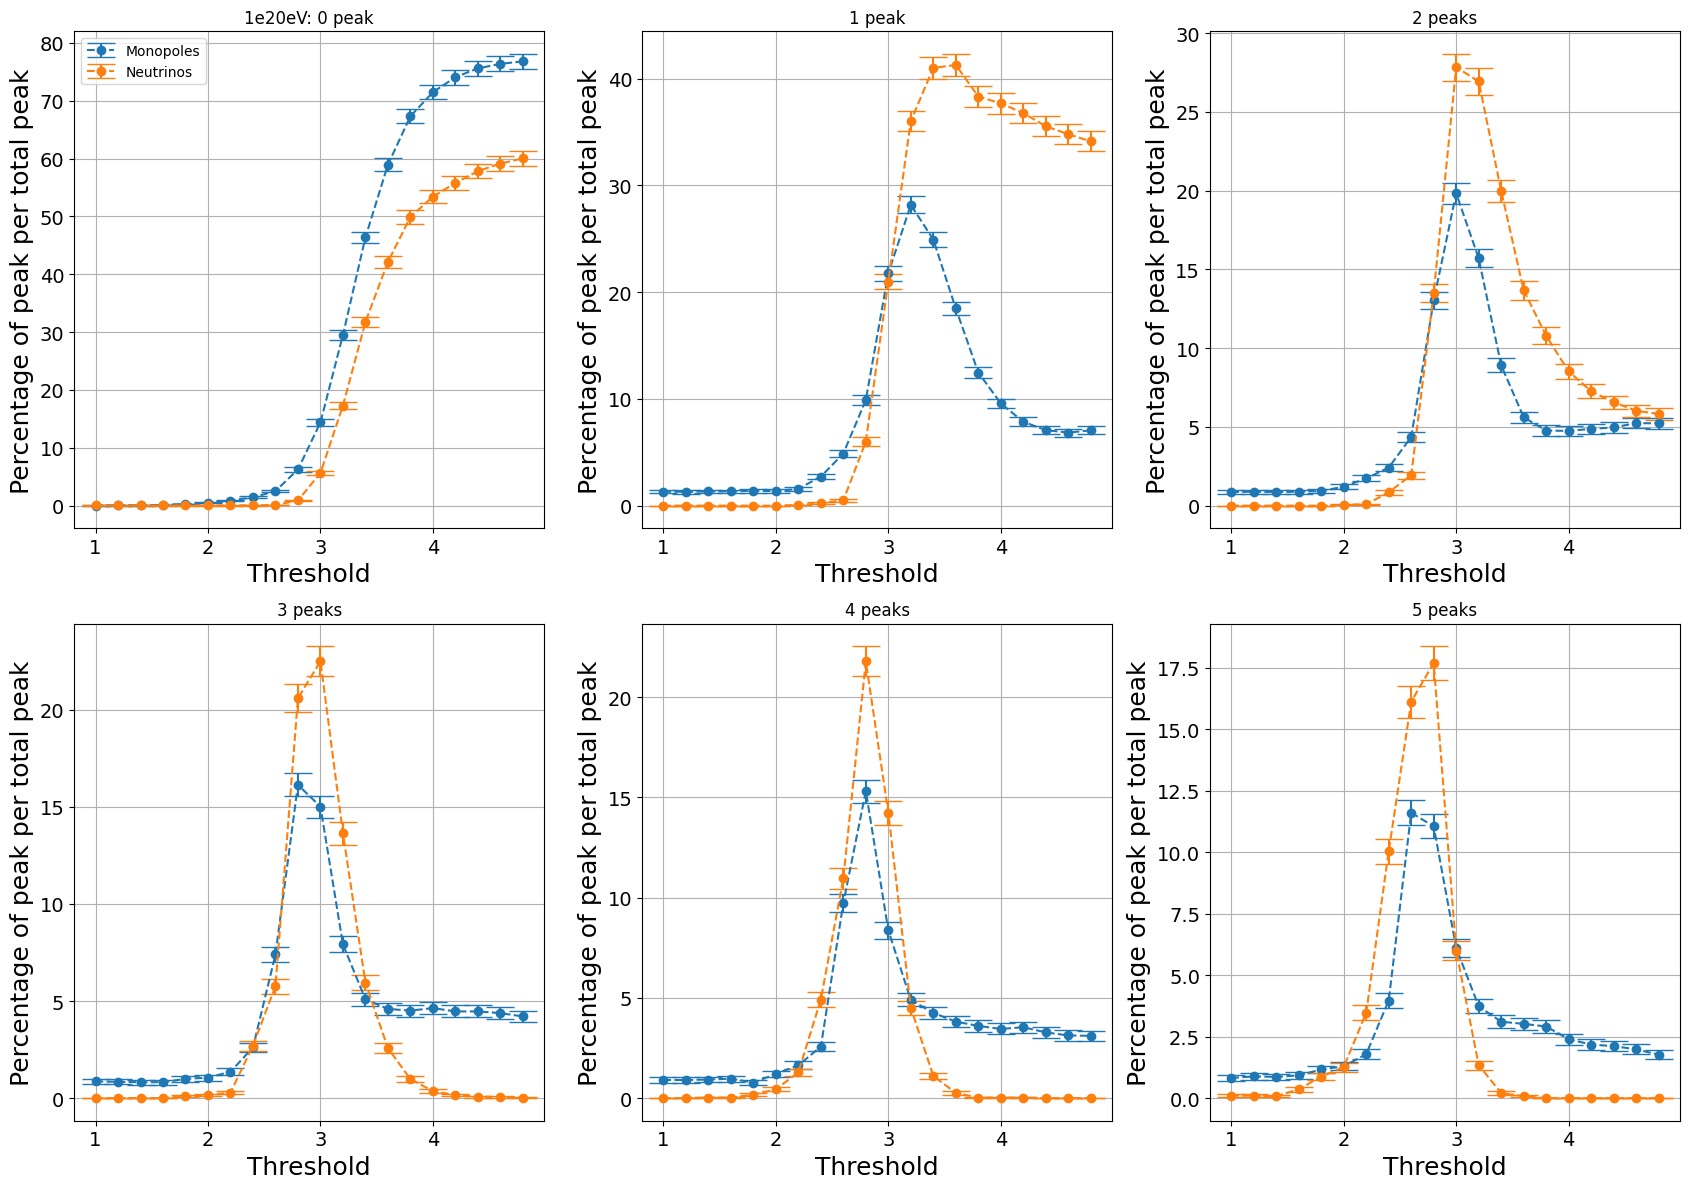

In [16]:
#Make 4 plots with 2 rows and 2 columns:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(17, 12))
ax1.errorbar(Threshold, p1[:,0], yerr=e1[:,0], fmt='o--', capsize= 10, label="Monopoles")
ax1.errorbar(Threshold, p2[:,0], yerr=e2[:,0], fmt='o--', capsize= 10, label="Neutrinos")

ax2.errorbar(Threshold, p1[:,1], yerr=e1[:,1], fmt='o--', capsize= 10, label="Monopoles")
ax2.errorbar(Threshold, p2[:,1], yerr=e2[:,1], fmt='o--', capsize= 10, label="Neutrinos")

ax3.errorbar(Threshold, p1[:,2], yerr=e1[:,2], fmt='o--', capsize= 10, label="Monopoles")
ax3.errorbar(Threshold, p2[:,2], yerr=e2[:,2], fmt='o--', capsize= 10, label="Neutrinos")

ax4.errorbar(Threshold, p1[:,3], yerr=e1[:,3], fmt='o--', capsize= 10, label="Monopoles")
ax4.errorbar(Threshold, p2[:,3], yerr=e2[:,3], fmt='o--', capsize= 10, label="Neutrinos")

ax5.errorbar(Threshold, p1[:,4], yerr=e1[:,4], fmt='o--', capsize= 10, label="Monopoles")
ax5.errorbar(Threshold, p2[:,4], yerr=e2[:,4], fmt='o--', capsize= 10, label="Neutrinos")

ax6.errorbar(Threshold, p1[:,5], yerr=e1[:,5], fmt='o--', capsize= 10, label="Monopoles")
ax6.errorbar(Threshold, p2[:,5], yerr=e2[:,5], fmt='o--', capsize= 10, label="Neutrinos")

ax1.set_title(f"1e{E}eV: 0 peak")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Percentage of peak per total peak")

ax1.grid()
ax1.legend()

ax2.set_title("1 peak")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Percentage of peak per total peak")

ax2.grid()

ax3.set_title("2 peaks")
ax3.set_xlabel("Threshold")
ax3.set_ylabel("Percentage of peak per total peak")

ax3.grid()

ax4.set_title("3 peaks")
ax4.set_xlabel("Threshold")
ax4.set_ylabel("Percentage of peak per total peak")

ax4.grid()

ax5.set_title("4 peaks")
ax5.set_xlabel("Threshold")
ax5.set_ylabel("Percentage of peak per total peak")

ax5.grid()

ax6.set_title("5 peaks")
ax6.set_xlabel("Threshold")
ax6.set_ylabel("Percentage of peak per total peak")

ax6.grid()
plt.tight_layout()
plt.show()

In [18]:
len(p1[:,5:]), len(Threshold)

(11, 11)

In [2]:
import numpy as np

# Original array
data = np.arange(100)

# Downsampling by selecting every Nth data point
N = 5
downsampled_data = data[::N]

print(downsampled_data)

[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]


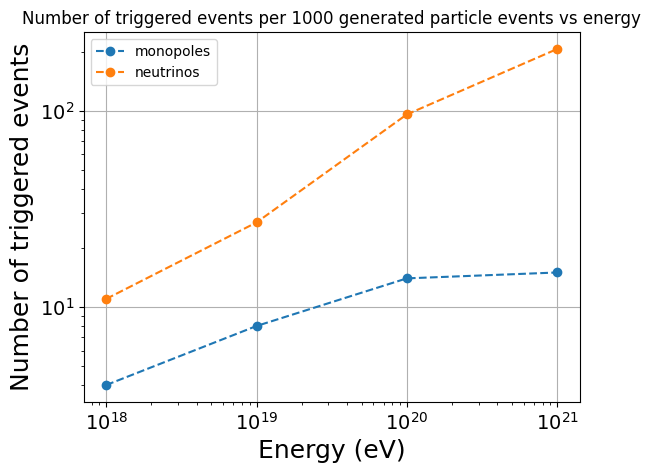

In [7]:
E = [1e18, 1e19, 1e20, 1e21]
MM = [4, 8, 14, 15]
Neu = [11, 27, 96, 207]
import matplotlib.pyplot as plt
plt.plot(E, MM, "o--", label = "monopoles")
plt.plot(E, Neu, "o--", label = "neutrinos")
plt.title("Number of triggered events per 1000 generated particle events vs energy")
plt.xlabel("Energy (eV)")
plt.ylabel("Number of triggered events")
plt.loglog()
plt.grid()
plt.legend()
plt.show()

In [7]:
E = [1e18, 1e19, 1e20]
import numpy as np
import matplotlib.pyplot as plt
########################################################################################################################
# For 100 ns:
r1 = np.array([[0.8866995073891626, 0.11330049261083744, 0, 0, 0], #1e18eV, 4 events 
               [0.9006342494714588, 0.09936575052854123, 0, 0, 0], #1e19eV, 8 events 
               [0.9407665505226481, 0.0545876887340302, 0.004645760743321719, 0, 0] #1e20eV, 14 events
               ])
r2 = np.array([[0.9096126255380201, 0.09038737446197992, 0, 0, 0], #1e18eV, 11 events
               [0.9132517296434274, 0.08568387440127727, 0.0010643959552953698, 0, 0], #1e19eV, 27 events
               [0.8709365947859672, 0.12294818152558738, 0.006115223688445446, 0, 0] #1e20eV, 96 events
               ])
########################################################################################################################
# For 500 ns:
r1_a = np.array([[0.7317073170731707, 0.1951219512195122, 0.07317073170731707, 0, 0], #1e18eV, 4 events
               [0.5789473684210527, 0.28421052631578947, 0.1368421052631579, 0, 0], #1e19eV, 8 events
               [0.7283236994219653, 0.17341040462427745, 0.08670520231213873, 0.005780346820809248, 0.005780346820809248]#1e20eV, 14 events
                ])
r2_a = np.array([[0.7214285714285714, 0.2571428571428571, 0.02142857142857143, 0, 0], #1e18eV, 11 events
               [0.651595744680851, 0.2845744680851064, 0.06382978723404255, 0, 0], #1e19eV, 27 events
                [0.5189058728881738, 0.2847948511665326, 0.1512469831053902, 0.032180209171359615, 0.012872083668543845] #1e20eV, 96 events
                ])
#################
r1 = np.array([[0.5609756097560976, 0.3170731707317073, 0.12195121951219512, 0, 0], #1e18eV, 4 events
               [0.5789473684210527, 0.28421052631578947, 0.1368421052631579, 0, 0], #1e19eV, 8 events
               [0.7514450867052023, 0.1676300578034682, 0.07514450867052024, 0.0, 0.005780346820809248] #1e20eV, 14 events
                ])
r2 = np.array([[0.6071428571428571, 0.32142857142857145, 0.07142857142857142, 0, 0], #1e18eV, 11 events
               [0.7272727272727273, 0.24675324675324675, 0.025974025974025976, 0, 0] , #1e19eV, 6 events
                [0.3942307692307692, 0.5096153846153846, 0.09615384615384616, 0, 0]  #1e20eV, 8 events
                ])
########################################################################################################################
#Turn to percentage
r1 = r1_a *100
r2 = r2_a *100
#Calculate the error:
e1 = np.sqrt(r1)
e2 = np.sqrt(r2)

In [8]:
print(e1)

[[8.55398923 4.41726104 2.7050089  0.         0.        ]
 [7.6088591  5.3311399  3.69921756 0.         0.        ]
 [8.5341883  4.16425749 2.94457471 0.76028592 0.76028592]]


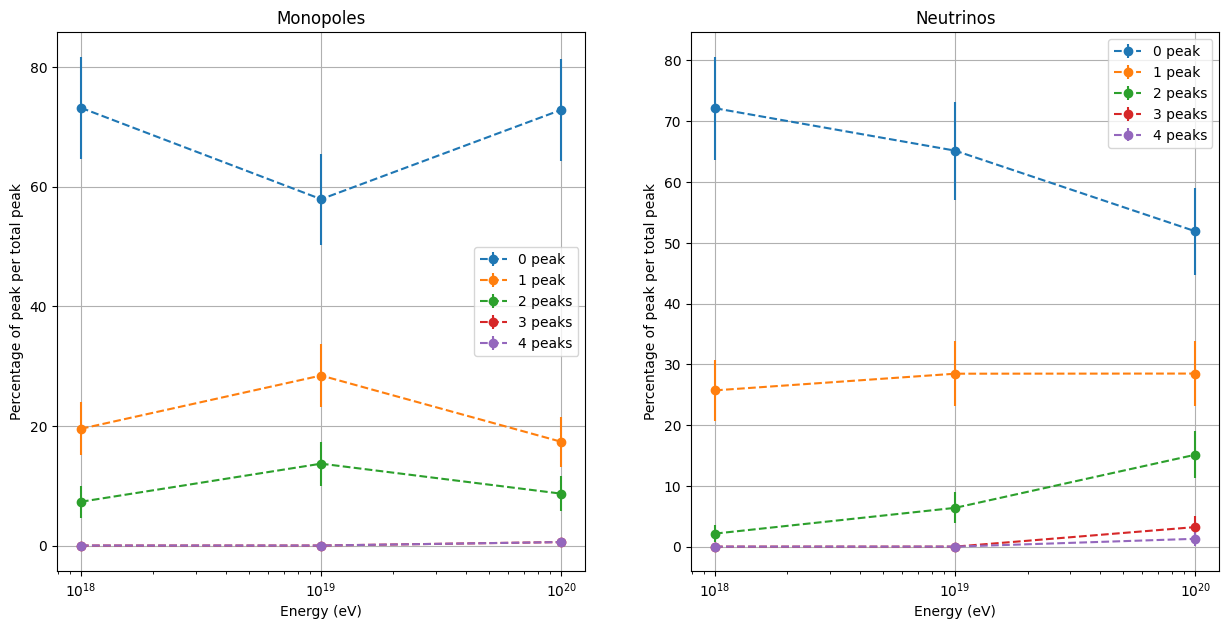

In [9]:
#Make side by side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.errorbar(E, r1[:,0], yerr = e1[:,0], fmt = "o--", label = "0 peak")
ax1.errorbar(E, r1[:,1], yerr = e1[:,1], fmt = "o--", label = "1 peak")
ax1.errorbar(E, r1[:,2], yerr = e1[:,2], fmt = "o--", label = "2 peaks")
ax1.errorbar(E, r1[:,3], yerr = e1[:,3], fmt = "o--", label = "3 peaks")
ax1.errorbar(E, r1[:,4], yerr = e1[:,4], fmt = "o--", label = "4 peaks")

ax2.errorbar(E, r2[:,0], yerr = e2[:,0], fmt = "o--", label = "0 peak")
ax2.errorbar(E, r2[:,1], yerr = e2[:,1], fmt = "o--", label = "1 peak")
ax2.errorbar(E, r2[:,2], yerr = e2[:,2], fmt = "o--", label = "2 peaks")
ax2.errorbar(E, r2[:,3], yerr = e2[:,3], fmt = "o--", label = "3 peaks")
ax2.errorbar(E, r2[:,4], yerr = e2[:,4], fmt = "o--", label = "4 peaks")

ax1.set_title("Monopoles")
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("Percentage of peak per total peak")
ax1.set_xscale("log")
ax1.grid()
ax1.legend()

ax2.set_title("Neutrinos")
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("Percentage of peak per total peak")
ax2.set_xscale("log")
ax2.grid()
ax2.legend()

plt.show()

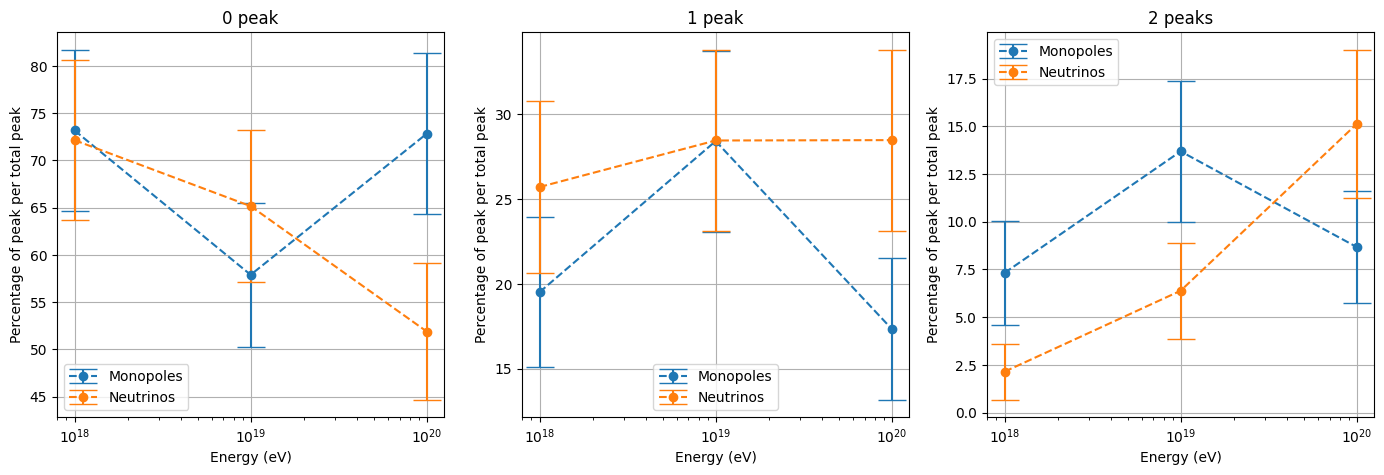

In [10]:
#make three plots next to each other:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))
ax1.errorbar(E, r1[:,0], yerr = e1[:,0], fmt = "o--", capsize=10, label = "Monopoles")
ax1.errorbar(E, r2[:,0], yerr = e2[:,0], fmt = "o--", capsize=10, label = "Neutrinos")

ax2.errorbar(E, r1[:,1], yerr = e1[:,1], fmt = "o--", capsize=10, label = "Monopoles")
ax2.errorbar(E, r2[:,1], yerr = e2[:,1], fmt = "o--", capsize=10, label = "Neutrinos")

ax3.errorbar(E, r1[:,2], yerr = e1[:,2], fmt = "o--", capsize=10, label = "Monopoles")
ax3.errorbar(E, r2[:,2], yerr = e2[:,2], fmt = "o--", capsize=10, label = "Neutrinos")

ax1.set_title("0 peak")
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("Percentage of peak per total peak")
ax1.set_xscale("log")
ax1.grid()
ax1.legend()

ax2.set_title("1 peak")
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("Percentage of peak per total peak")
ax2.set_xscale("log")
ax2.grid()
ax2.legend()

ax3.set_title("2 peaks")
ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel("Percentage of peak per total peak")
ax3.set_xscale("log")
ax3.grid()
ax3.legend()


plt.show()


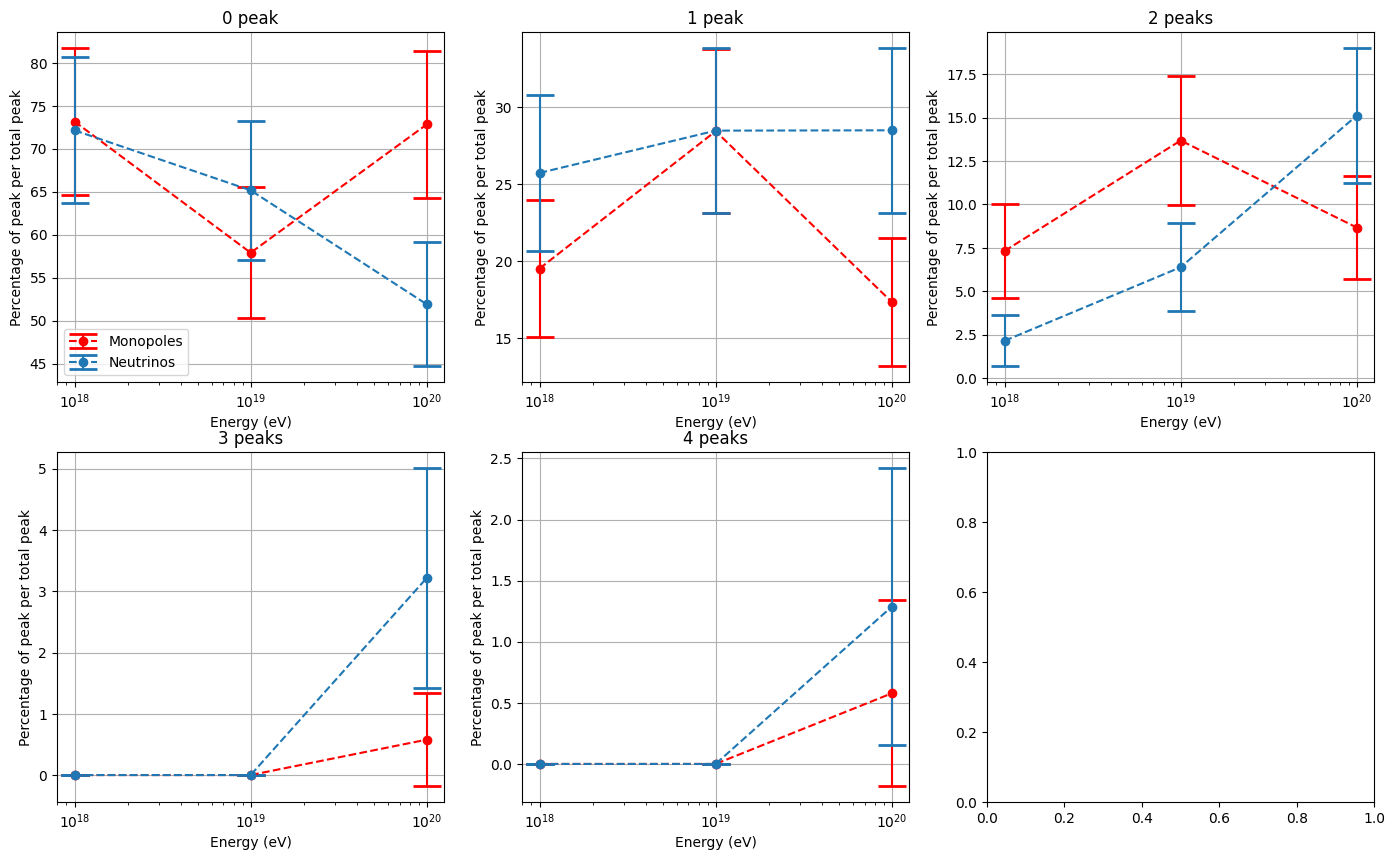

In [11]:
#Make 4 plots with 2 rows and 2 columns:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(17, 10))
ax1.errorbar(E, r1[:,0], yerr = e1[:,0], color = "red", fmt = "o--", capsize=10, capthick=2, label = "Monopoles")
ax1.errorbar(E, r2[:,0], yerr = e2[:,0], fmt = "o--", capsize=10, capthick=2, label = "Neutrinos")

ax2.errorbar(E, r1[:,1], yerr = e1[:,1], color = "red", fmt = "o--", capsize=10, capthick=2, label = "Monopoles")
ax2.errorbar(E, r2[:,1], yerr = e2[:,1], fmt = "o--", capsize=10, capthick=2, label = "Neutrinos")

ax3.errorbar(E, r1[:,2], yerr = e1[:,2], color = "red", fmt = "o--", capsize=10, capthick=2, label = "Monopoles")
ax3.errorbar(E, r2[:,2], yerr = e2[:,2], fmt = "o--", capsize=10, capthick=2, label = "Neutrinos")

ax4.errorbar(E, r1[:,3], yerr = e1[:,3], color = "red", fmt = "o--", capsize=10, capthick=2, label = "Monopoles")
ax4.errorbar(E, r2[:,3], yerr = e2[:,3], fmt = "o--", capsize=10, capthick=2, label = "Neutrinos")

ax5.errorbar(E, r1[:,4], yerr = e1[:,4], color = "red", fmt = "o--", capsize=10, capthick=2, label = "Monopoles")
ax5.errorbar(E, r2[:,4], yerr = e2[:,4], fmt = "o--", capsize=10, capthick=2, label = "Neutrinos")

ax1.set_title("0 peak")
ax1.set_xlabel("Energy (eV)")
ax1.set_ylabel("Percentage of peak per total peak")
ax1.set_xscale("log")
ax1.grid()
ax1.legend()

ax2.set_title("1 peak")
ax2.set_xlabel("Energy (eV)")
ax2.set_ylabel("Percentage of peak per total peak")
ax2.set_xscale("log")
ax2.grid()

ax3.set_title("2 peaks")
ax3.set_xlabel("Energy (eV)")
ax3.set_ylabel("Percentage of peak per total peak")
ax3.set_xscale("log")
ax3.grid()

ax4.set_title("3 peaks")
ax4.set_xlabel("Energy (eV)")
ax4.set_ylabel("Percentage of peak per total peak")
ax4.set_xscale("log")
ax4.grid()

ax5.set_title("4 peaks")
ax5.set_xlabel("Energy (eV)")
ax5.set_ylabel("Percentage of peak per total peak")
ax5.set_xscale("log")
ax5.grid()

plt.show()

In [ ]:
#Energy =  1e18
threshold = [1, 2, 3, 4, 5]
p1 = np.array([[], #4 events
               #[0.0, 0.0, 0.0, 0.0, 0.0], #8 events
                #[0.0, 0.0, 0.0, 0.0, 0.0] #14 events
                ])
p2 = np.array([[0.0, 0.0, 0.0, 0.0, 0.0], #11 events
                #[0.0, 0.0, 0.0, 0.0, 0.0], #27 events
                #[0.0, 0.0, 0.0, 0.0, 0.0] #96 events
                ])


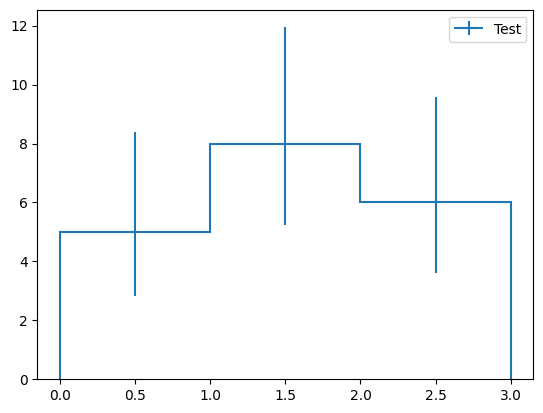

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
bins = [0,1,2,3]
h = [5,8,6]
f, ax = plt.subplots()
hep.histplot(h, bins, yerr=True,
label="Test")
ax.legend()

